In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from joblib import dump, load
from kafka import KafkaConsumer, KafkaProducer
import json

In [2]:
df = pd.read_csv("Customer-Churn-Records.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
rows, columns = df.shape
duplicate = df.duplicated().sum()
single_value = [x for x in df.columns if df[x].nunique() < 2]
boolean_like = [x for x in df.columns if df[x].dropna().nunique() == 2]
null_sum = df.isnull().sum().sum()

dtype_counts = df.dtypes.apply(lambda x: x.name).value_counts()
formatted_list = [f"{dtype}({count})" for dtype, count in dtype_counts.items()]
formattedd = ', '.join(formatted_list[:-1]) + ' and ' + formatted_list[-1] if len(formatted_list) > 1 else formatted_list[0]

def pluralize(word, count):
    return f"{count} {word}{'' if count == 1 else 's'}"

print(f"The Dataset contains {pluralize('Column', columns)} and {pluralize('Row', rows)}\n"
      f"The Data Types are {formattedd}\n"
      f"{pluralize('Row', duplicate)} consist of duplicate values\n"
      f"{pluralize('Column', len(single_value))} consist of a single value\n"
      f"{pluralize('Column', len(boolean_like))} consist of boolean-like values\n"
      f"{pluralize('Null value', null_sum)} are present")

df.head()

The Dataset contains 18 Columns and 10000 Rows
The Data Types are int64(12), object(4) and float64(2)
0 Rows consist of duplicate values
0 Columns consist of a single value
5 Columns consist of boolean-like values
0 Null values are present


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [5]:
df.drop(columns=['RowNumber', 'CustomerId',	'Surname'], inplace = True)

In [6]:
df.rename(columns={'Gender': 'IsMale', 'Satisfaction Score':'SatisfactionScore', 'Card Type': 'CardType'}, inplace=True)

In [7]:
df['Geography'] = df['Geography'].map({'France': 1, 'Germany': 2, 'Spain': 3})
df['IsMale'] = df['IsMale'].map({'Female': 0, 'Male': 1})
df['CardType'] = df['CardType'].map({'DIAMOND': 1, 'GOLD': 2, 'SILVER': 3, 'PLATINUM': 4})

In [8]:
for col in df.select_dtypes(include=['number']):
    if set(df[col].dropna().unique()) == {0, 1}:
        df[col] = df[col].astype(bool)

In [9]:
category = ['Geography', 'CardType', 'SatisfactionScore']

In [10]:
for col in category:
    df[col] = df[col].astype('category')

In [11]:
df.dtypes

CreditScore             int64
Geography            category
IsMale                   bool
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard                bool
IsActiveMember           bool
EstimatedSalary       float64
Exited                   bool
Complain                 bool
SatisfactionScore    category
CardType             category
Point Earned            int64
dtype: object

In [12]:
df.isnull().sum().sum()

0

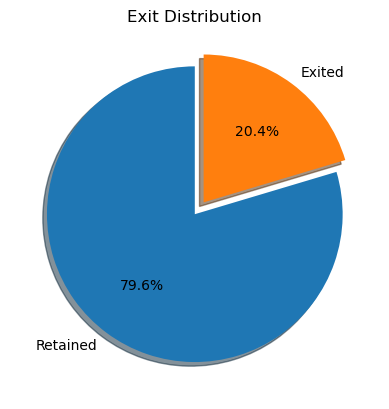

In [13]:
plt.pie(
    df['Exited'].value_counts(),
    explode=(0,0.1),
    startangle=90,
    labels=['Retained', 'Exited'],
    shadow=True,
    autopct='%1.1f%%'
)
plt.title('Exit Distribution')
plt.show()

<Axes: xlabel='IsActiveMember', ylabel='count'>

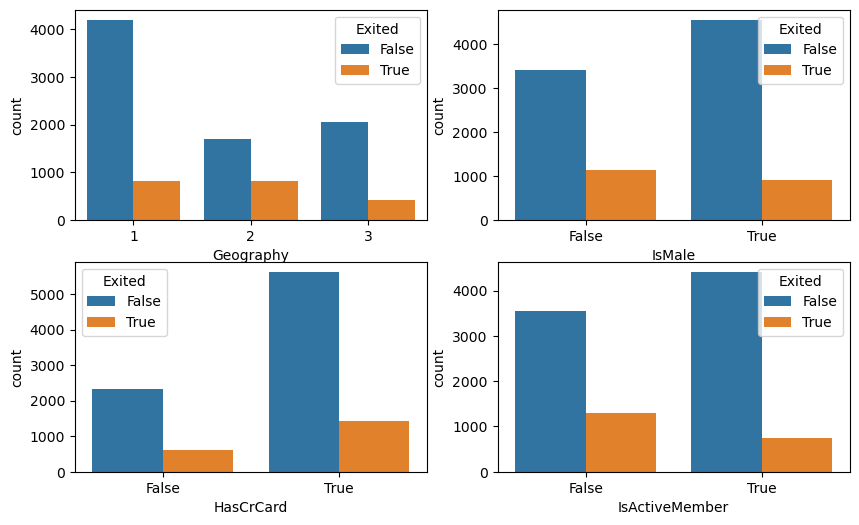

In [14]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='IsMale', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

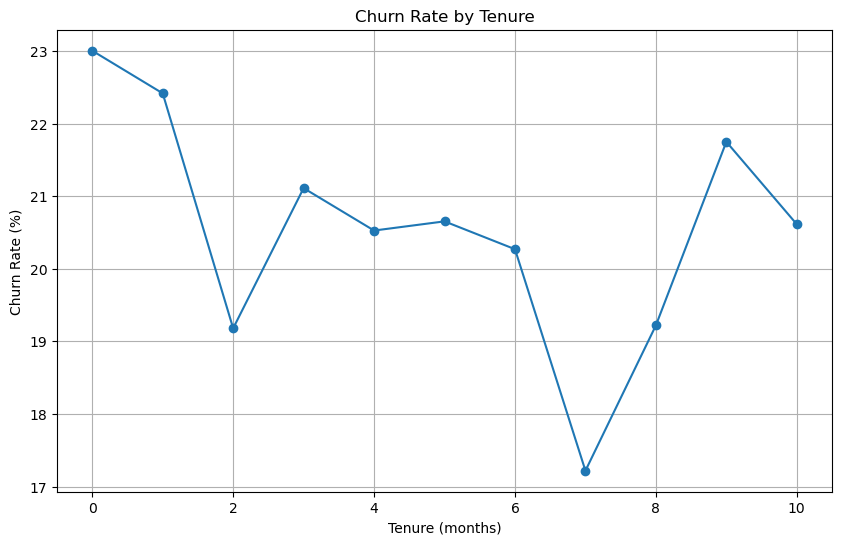

In [15]:
# Ensure Exited is numeric
df['Exited'] = df['Exited'].astype(int)

# Compute churn rate (as a percentage)
avg_churn_by_tenure = df.groupby('Tenure')['Exited'].mean() * 100

# Plotting
plt.figure(figsize=(10,6))
avg_churn_by_tenure.plot(kind='line', marker='o')
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Churn Rate (%)')  # Note the % here
plt.grid(True)
plt.show()

In [16]:
x=df.drop(columns=['Exited'])
y=df['Exited']

In [17]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=11)

In [18]:
category_index = [df.columns.get_loc(col) for col in df.select_dtypes(include=['category', 'bool']).columns]

In [19]:
smote_nc = SMOTENC(categorical_features=category_index, random_state=70)
xtrain_s, ytrain_s = smote_nc.fit_resample(xtrain, ytrain)

before_counts = ytrain.value_counts().sort_index()
after_counts = pd.Series(ytrain_s).value_counts().sort_index()

distribution_df = pd.DataFrame({
    'Exited': before_counts.index,
    'Before': before_counts.values,
    'After': after_counts.values
})
distribution_df.index = distribution_df.index + 1
distribution_df

,Exited,Before,After
1,0,5981,5981
2,1,1519,5981


In [20]:
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
xtrain_s[num_cols] = scaler.fit_transform(xtrain_s[num_cols])
xtest[num_cols] = scaler.transform(xtest[num_cols])

In [21]:
# 6. Define your models
models = {
    "LogisticRegression": LogisticRegression(C=0.01, max_iter=500, penalty='l1', solver='liblinear'),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM": SVC(max_iter=5000, probability=True),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(enable_categorical=True, eval_metric='logloss')

}

# 7. Train, test, and evaluate
results = []

for name, model in models.items():
    print(f"\n=== {name} ===")

    model.fit(xtrain_s, ytrain_s)
    y_pred = model.predict(xtest)
    y_prob = model.predict_proba(xtest)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(ytest, y_pred)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print("Classification Report:\n", classification_report(ytest, y_pred))

    if y_prob is not None:
        roc = roc_auc_score(ytest, y_prob)
        print(f"ROC AUC Score: {roc:.4f}")

    # 8. Cross-validation on full dataset
    x_scaled = x.copy()
    x_scaled[num_cols] = scaler.transform(x_scaled[num_cols])
    cv_scores = cross_val_score(model, x_scaled, y, cv=5)
    print(f"Cross-validated Accuracy: {cv_scores.mean():.4f}")

    results.append((name, acc, cv_scores.mean()))

# 9. Summary
print("\n=== Model Summary ===")
for name, acc, cv_acc in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:20s} Test Acc: {acc:.4f} | CV Acc: {cv_acc:.4f}")


=== LogisticRegression ===
Test Accuracy: 99.84%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1981
           1       0.99      1.00      1.00       519

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

ROC AUC Score: 0.9983
Cross-validated Accuracy: 0.9986

=== DecisionTree ===
Test Accuracy: 99.80%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1981
           1       0.99      1.00      1.00       519

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

ROC AUC Score: 0.9980
Cross-validated Accuracy: 0.9965

=== SVM ===
Test Accuracy: 99.84%
Classification Report:
               precision    recall  

In [22]:
results = []

for name, model in models.items():
    model.fit(xtrain_s, ytrain_s)
    y_pred = model.predict(xtest)
    y_prob = model.predict_proba(xtest)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(ytest, y_pred)
    clf_report = classification_report(ytest, y_pred, output_dict=True)
    precision_0 = clf_report['0']['precision']
    precision_1 = clf_report['1']['precision']

    # Cross-validation on full dataset
    x_scaled = x.copy()
    x_scaled[num_cols] = scaler.transform(x_scaled[num_cols])
    cv_scores = cross_val_score(model, x_scaled, y, cv=5)
    cv_mean = cv_scores.mean()

    results.append({
        "Model": name,
        "Test Accuracy": round(acc, 3),
        "Model Accuracy": round(cv_mean, 3),
        "Precision (0|1)": f"{precision_0:.2f} | {precision_1:.2f}"
    })

# 9. Create summary DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Test Accuracy,Model Accuracy,Precision (0|1)
0,LogisticRegression,0.998,0.999,1.00 | 0.99
1,DecisionTree,0.998,0.997,1.00 | 0.99
2,SVM,0.998,0.999,1.00 | 0.99
3,RandomForest,0.998,0.999,1.00 | 0.99
4,XGBoost,0.998,0.998,1.00 | 0.99


In [23]:
from sklearn.metrics import roc_auc_score

results = []

for name, model in models.items():
    model.fit(xtrain_s, ytrain_s)
    y_pred = model.predict(xtest)
    y_prob = model.predict_proba(xtest)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(ytest, y_pred)
    clf_report = classification_report(ytest, y_pred, output_dict=True)
    precision_0 = clf_report['0']['precision']
    precision_1 = clf_report['1']['precision']

    # ROC AUC
    roc_auc = roc_auc_score(ytest, y_prob) if y_prob is not None else None

    # Cross-validation on full dataset
    x_scaled = x.copy()
    x_scaled[num_cols] = scaler.transform(x_scaled[num_cols])
    cv_scores = cross_val_score(model, x_scaled, y, cv=5)
    cv_mean = cv_scores.mean()

    results.append({
        "Model": name,
        "Test Accuracy": round(acc, 3),
        "Model Accuracy": round(cv_mean, 3),
        "Precision (0|1)": f"{precision_0:.2f} | {precision_1:.2f}",
        "ROC AUC": round(roc_auc, 3) if roc_auc is not None else "N/A"
    })

# 9. Create summary DataFrame
results_df = pd.DataFrame(results)
results_df


,Model,Test Accuracy,Model Accuracy,Precision (0|1),ROC AUC
0,LogisticRegression,0.998,0.999,1.00 | 0.99,0.998
1,DecisionTree,0.998,0.997,1.00 | 0.99,0.998
2,SVM,0.998,0.999,1.00 | 0.99,0.999
3,RandomForest,0.998,0.999,1.00 | 0.99,0.999
4,XGBoost,0.998,0.998,1.00 | 0.99,0.999
